In [14]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM
from scipy.optimize import minimize_scalar

project_root = Path.cwd().parent
print(f"Project root: {project_root}")

Project root: /Users/david/Code/msc


In [15]:
# User input: run folder name
run_name = input("Enter the run name: ").strip()
run_folder = project_root / "runs" / run_name
distance_process_path = run_folder / "distance_process.csv"

if not distance_process_path.exists():
    raise FileNotFoundError(f"No distance_process.csv found at {distance_process_path}")

df = pd.read_csv(distance_process_path)

# Use redshift from ztf_cleansed for the Hubble diagram
ztf_cleansed_path = project_root / "ztf_cleansed.csv"
ztf_df = pd.read_csv(ztf_cleansed_path)
z_from_ztf = df["ztf_id"].map(ztf_df.set_index("ZTFID")["redshift"])
df["host_redshift"] = z_from_ztf.fillna(df["host_redshift"])

# Filter to z > 0 and sort by redshift for plotting
dfp = df[df["host_redshift"] > 0].sort_values("host_redshift").copy()
# Drop invalid rows for distance moduli or residuals
valid = np.isfinite(dfp["distance_modulus_u_obs"]) & np.isfinite(dfp["mu_th"]) & np.isfinite(dfp["resid"])
dfp = dfp.loc[valid]
if len(dfp) < len(df):
    print(f"Dropped {len(df) - len(dfp)} rows")
print(f"Loaded {len(dfp)} objects from {distance_process_path}")
dfp.head()

Loaded 423 objects from /Users/david/Code/msc/runs/test4/distance_process.csv


,ztf_id,host_redshift,ncall,ndof,chisq,t0,x0,x1,c,apparent_mag_B,distance_modulus_u_obs,mu_th,resid
349,ZTF19aacgslb,0.004520,109,102,27059.171339,58510.552516,0.083152,-0.084587,0.010775,13.208455,32.568455,31.441887,1.126568
249,ZTF18acbvgqw,0.008673,119,17,555.743431,58438.641469,0.053969,-2.284826,-0.031314,13.676057,33.036057,32.863963,0.172095
90,ZTF18aawlfnj,0.010000,115,28,228.045933,60149.074035,0.007312,0.068994,0.123148,15.849467,35.209467,33.175318,2.034148
313,ZTF18acwutbr,0.011000,102,24,176.893959,58483.033806,0.005028,-0.117851,0.112144,16.256028,35.616028,33.383939,2.232089
372,ZTF19aahjhoy,0.013696,186,4,44.819387,58511.789895,0.003516,-2.305176,0.578572,16.653226,36.013226,33.864399,2.148827


Best-fit H0 = 62.9 km/s/Mpc
Saved to /Users/david/Code/msc/runs/test4/hubble_diagram.png


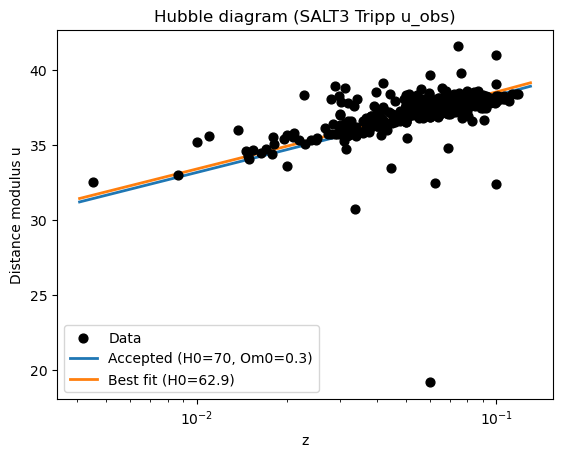

Saved to /Users/david/Code/msc/runs/test4/hubble_residuals.png


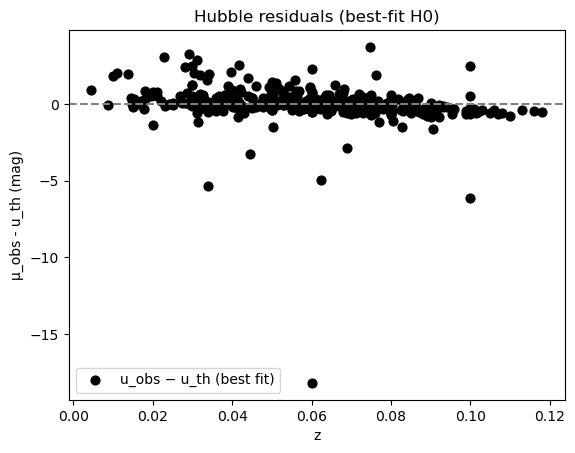

In [17]:
# Pull out numpy arrays
z_data = dfp["host_redshift"].to_numpy()
mu_obs = dfp["distance_modulus_u_obs"].to_numpy()

Om0 = 0.3  # fixed matter density for all models

def mu_theory(z, H0, Om0=Om0):
    """Distance modulus u(z) for flat ΛCDM."""
    return FlatLambdaCDM(H0=H0, Om0=Om0).distmod(z).value

# Fit H0 
def loss(H0):
    """Sum of squared u residuals for a given H0."""
    return np.sum((mu_obs - mu_theory(z_data, H0)) ** 2)

res = minimize_scalar(loss, bounds=(50, 100), method="bounded")
H0_best = float(res.x)
print(f"Best-fit H0 = {H0_best:.1f} km/s/Mpc")

# Smooth z grid for theory curves (so ΛCDM curvature is visible)
z_min = max(1e-4, z_data.min() * 0.9)
z_max = z_data.max() * 1.1
z_smooth = np.logspace(np.log10(z_min), np.log10(z_max), 300)

# Hubble diagram
plt.figure()
plt.xscale("log")

plt.scatter(dfp["host_redshift"], dfp["distance_modulus_u_obs"], label="Data", color="black", s=40, zorder=5)

plt.plot(z_smooth, mu_theory(z_smooth, H0=70.0), label="Accepted (H0=70, Om0=0.3)", lw=2)

plt.plot(z_smooth, mu_theory(z_smooth, H0_best), label=f"Best fit (H0={H0_best:.1f})", lw=2)

plt.xlabel("z")
plt.ylabel("Distance modulus u")
plt.title("Hubble diagram (SALT3 Tripp u_obs)")
plt.legend()

out_path = run_folder / "hubble_diagram.png"
plt.savefig(out_path, dpi=150)
print(f"Saved to {out_path}")
plt.show()

# Residuals: u_obs − u_th for best-fit.  - brighter,  + dimmer 
mu_th_best = mu_theory(z_data, H0_best)
resid_best = mu_obs - mu_th_best

plt.figure()
plt.axhline(0, color="gray", ls="--")
plt.scatter(dfp["host_redshift"], resid_best, label="u_obs − u_th (best fit)", color="black", s=40)

plt.xlabel("z")
plt.ylabel("μ_obs - u_th (mag)")
plt.title("Hubble residuals (best-fit H0)")
plt.legend()

resid_path = run_folder / "hubble_residuals.png"
plt.savefig(resid_path, dpi=150)
print(f"Saved to {resid_path}")
plt.show()
